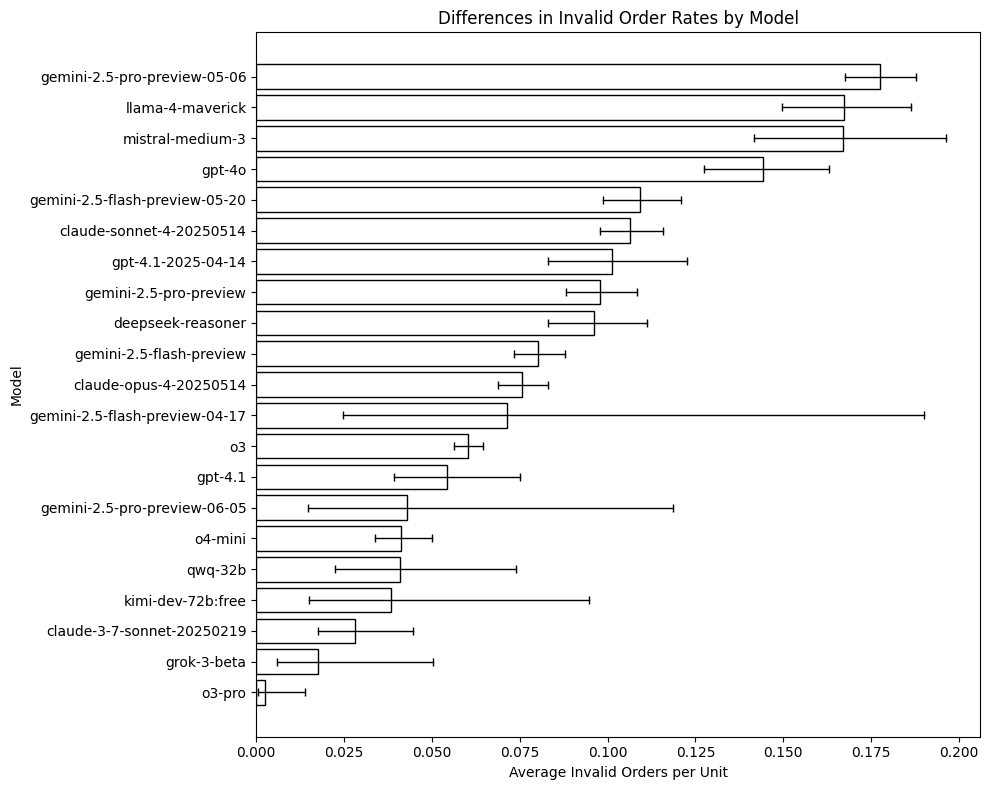

In [1]:
# Complete, self-contained cell (just run it)

import pandas as pd
from io import StringIO
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

# ── raw results pasted from your CSV ────────────────────────────────────────────
csv_data = """model_short_name,Total Unit-Orders Given,Total Invalid Orders Given,Average Errors per Unit
phi-4-reasoning-plus,90,0.0,0.0
o3-pro,408,1.0,0.0024509803921568627
grok-3-beta,171,3.0,0.017543859649122806
qwen3-235b-a22b,56,1.0,0.017857142857142856
deepseek-chat-v3-0324,156,4.0,0.02564102564102564
claude-3-7-sonnet-20250219,604,17.0,0.028145695364238412
kimi-dev-72b:free,104,4.0,0.038461538461538464
qwq-32b,244,10.0,0.040983606557377046
o4-mini,2357,97.0,0.041154009333899025
gemini-2.5-pro-preview-06-05,70,3.0,0.04285714285714286
gpt-4.1,626,34.0,0.054313099041533544
o3,12558,757.0,0.06028029941073419
gemini-2.5-flash-preview-04-17,42,3.0,0.07142857142857142
claude-opus-4-20250514,5195,393.0,0.07564966313763234
gemini-2.5-flash-preview,5342,429.0,0.08030700112317483
llama-4-maverick:free,192,16.0,0.08333333333333333
gemini-2.5-pro-preview-03-25,354,34.0,0.096045197740113
deepseek-reasoner,1715,165.0,0.09620991253644315
gemini-2.5-pro-preview,3296,322.0,0.09769417475728155
gpt-4.1-2025-04-14,890,90.0,0.10112359550561797
claude-sonnet-4-20250514,4560,485.0,0.10635964912280702
gemini-2.5-flash-preview-05-20,3029,331.0,0.10927698910531529
command-a,66,9.0,0.13636363636363635
gpt-4o,1497,216.0,0.14428857715430862
hermes-3-llama-3.1-405b,340,56.0,0.16470588235294117
magistral-medium-2506:thinking,217,36.0,0.16589861751152074
mistral-medium-3,718,120.0,0.1671309192200557
llama-4-maverick,1603,268.0,0.1671865252651279
gemini-2.5-pro-preview-05-06,5457,968.0,0.17738684258750229
gemini-2.5-flash-lite-preview-06-17,62,11.0,0.1774193548387097
exaone-deep-32b,128,27.0,0.2109375
llama-3.3-70b-instruct:free,34,9.0,0.2647058823529412
gemma-3-27b-it,157,50.0,0.3184713375796178
deephermes-3-mistral-24b-preview:free,110,82.0,0.7454545454545455
AFM-4.5B-Preview,46,48.0,1.0434782608695652
"""

summary = pd.read_csv(StringIO(csv_data))

# ── choose which models to plot (skip any that aren’t present) ────────────────
top_models = [
    'o3', 'gemini-2.5-pro-preview-05-06', 'claude-opus-4-20250514',
    'gemini-2.5-flash-preview-05-20', 'o4-mini', 'claude-sonnet-4-20250514',
    'llama-4-maverick', 'kimi-dev-72b:free', 'deepseek-reasoner',
    'gemini-2.5-flash-preview', 'grok-3-beta', 'gemini-2.5-pro-preview',
    'gpt-4o', 'gpt-4.1-2025-04-14', 'mistral-medium-3',
    'gemini-2.5-flash-preview-04-17', 'claude-3-7-sonnet-20250219',
    'o3-pro', 'qwq-32b', 'gemini-2.5-pro-preview-06-05', 'gpt-4.1'
]

summary = summary[summary["model_short_name"].isin(top_models)].copy()

# ── Wilson score 95 % confidence intervals for error proportion ──────────────
ci = summary.apply(
    lambda r: proportion_confint(
        count=r["Total Invalid Orders Given"],
        nobs=r["Total Unit-Orders Given"],
        method="wilson"
    ),
    axis=1,
)
ci = pd.DataFrame(ci.tolist(), columns=["ci_lower", "ci_upper"], index=summary.index)
summary = pd.concat([summary, ci], axis=1)

# sort for cleaner y-axis order
summary.sort_values("Average Errors per Unit", inplace=True)

# ── plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(
    summary["model_short_name"],
    summary["Average Errors per Unit"],
    color="white",
    edgecolor="black",
)

# whiskers for confidence intervals
for y, (_, row) in enumerate(summary.iterrows()):
    ax.plot(
        [row["ci_lower"], row["ci_upper"]],
        [y, y],
        "k-",
        lw=1,
        marker="|",
        markersize=6,
        markeredgewidth=1,
    )

ax.set_xlabel("Average Invalid Orders per Unit")
ax.set_ylabel("Model")
ax.set_title("Differences in Invalid Order Rates by Model")
ax.grid(axis="x", visible=False)
plt.tight_layout()
plt.show()


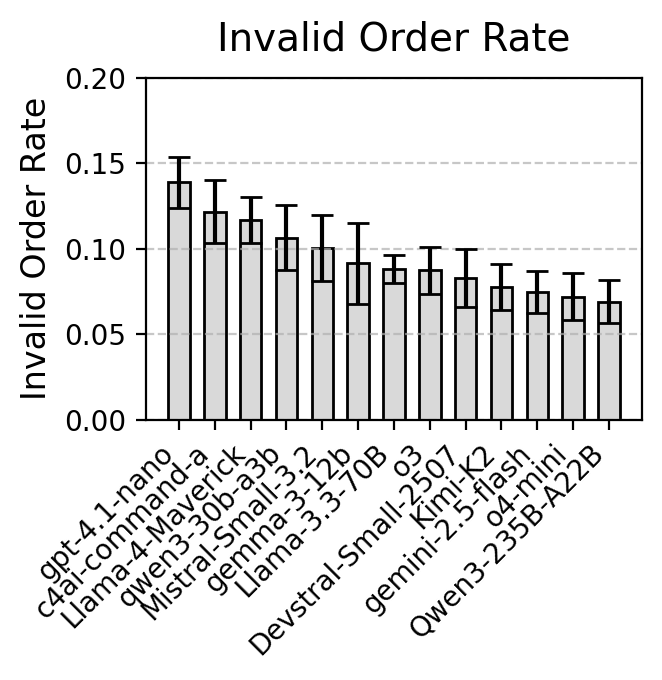

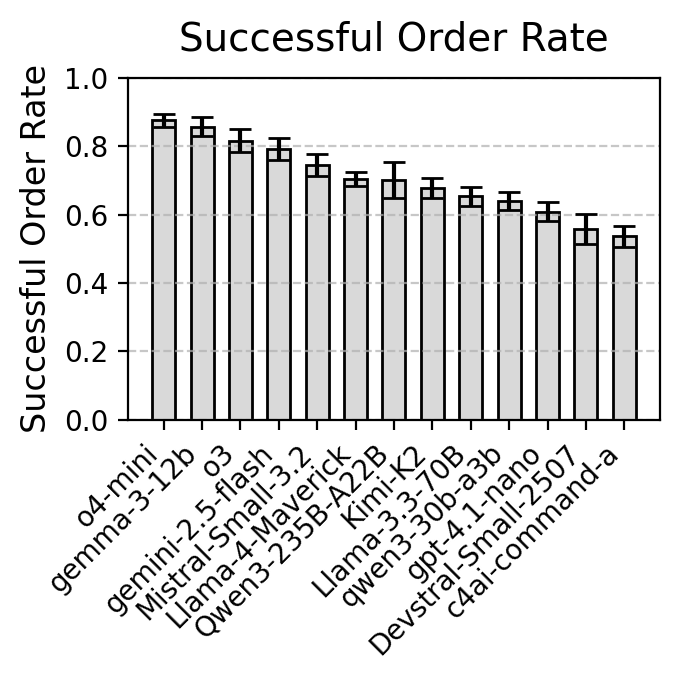

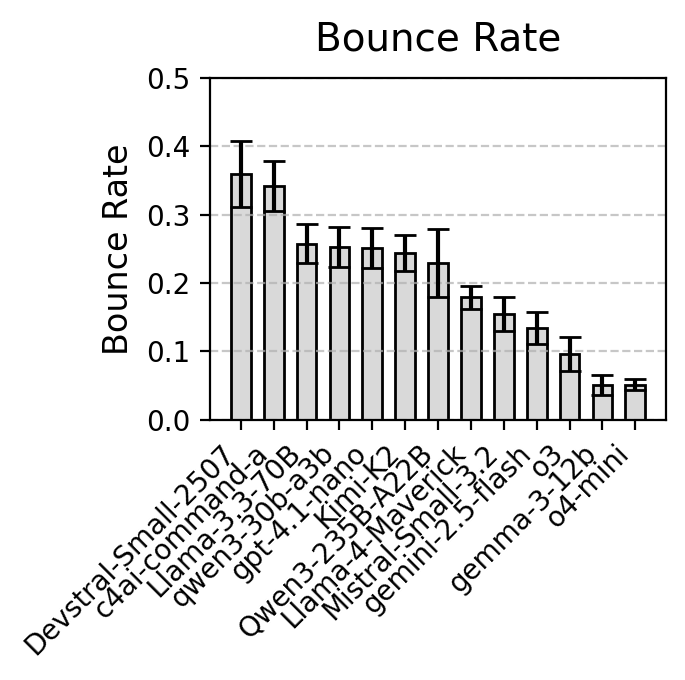

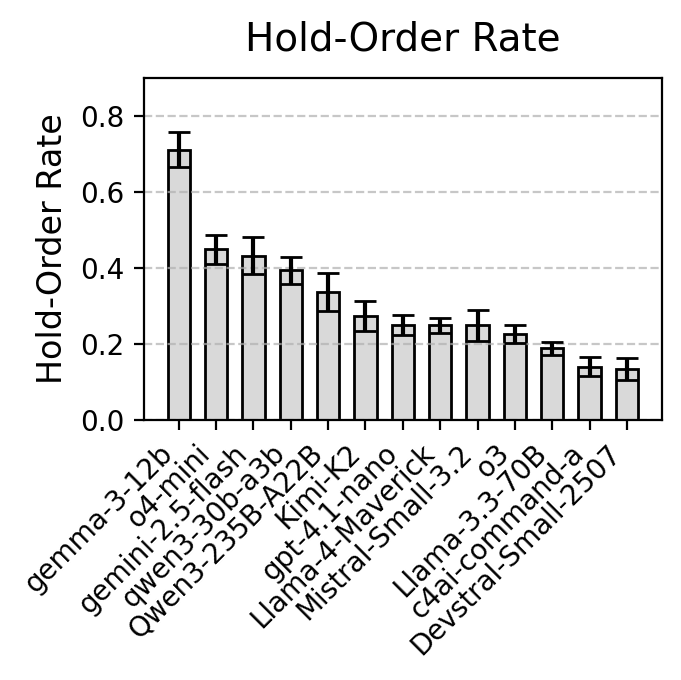

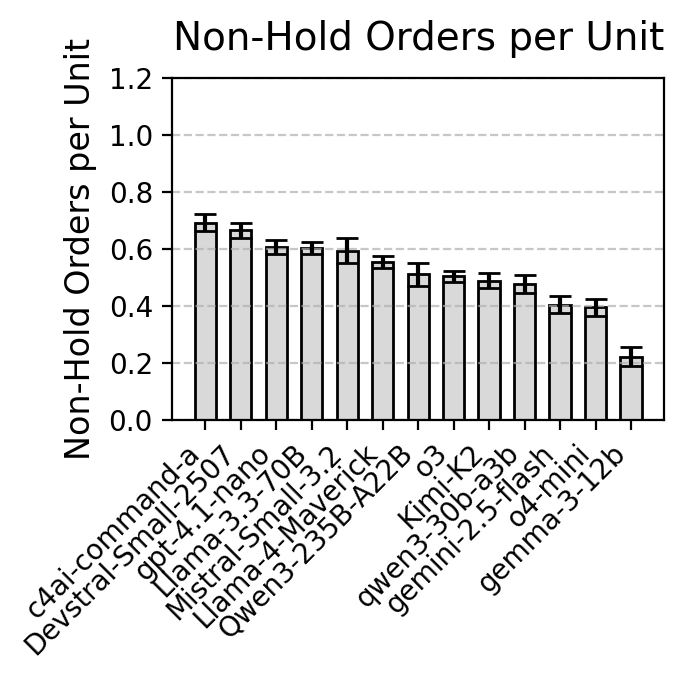

In [3]:
# ╔═════════════════════════════════════════════════════════════════════════╗
# ║  France order-quality analysis across multiple experiments              ║
# ╚═════════════════════════════════════════════════════════════════════════╝
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── 1  Experiments to evaluate ─────────────────────────────────────────────
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash",
    "../data/sam-exp089-bench": "c4ai-command-a",
    "../data/sam-exp091-bench": "Llama-4-Maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
    "../data/sam-exp118-bench": "gemma-3-12b",
    "../data/sam-exp119-bench": "qwen3-30b-a3b",
}

# ── 2  Helpers ─────────────────────────────────────────────────────────────
def classify_result(result: str) -> str:
    """Return one of success / bounce / invalid / other based on the result string."""
    r = result.lower()
    if "invalid" in r or "void" in r:
        return "invalid"
    if "success" in r:
        return "success"
    if "bounce" in r or "cut" in r:
        return "bounce"
    return "other"

def analyse_game(json_path: Path) -> dict:
    """Return aggregate France metrics for a single lmvsgame.json file."""
    with json_path.open() as f:
        game = json.load(f)

    total_orders = 0
    counts = {"invalid": 0, "success": 0, "bounce": 0}
    hold_orders = 0
    non_hold_orders = 0
    total_units_seen = 0

    for phase in game.get("phases", []):
        state = phase.get("state", {})
        france_units = state.get("units", {}).get("FRANCE", [])
        total_units_seen += len(france_units)

        order_results = phase.get("order_results", {}).get("FRANCE", {})
        for order_type, orders in order_results.items():
            for entry in orders:
                total_orders += 1
                res_type = classify_result(entry.get("result", ""))
                if res_type in counts:
                    counts[res_type] += 1
                if order_type.lower() == "hold":
                    hold_orders += 1
                else:
                    non_hold_orders += 1

    if total_orders == 0 or total_units_seen == 0:
        return None  # skip pathological cases

    return {
        "invalid_rate": counts["invalid"] / total_orders,
        "success_rate": counts["success"] / total_orders,
        "bounce_rate": counts["bounce"] / total_orders,
        "hold_rate": hold_orders / total_orders,
        "non_hold_per_unit": non_hold_orders / total_units_seen,
    }

# ── 3  Collect per-game records ────────────────────────────────────────────
records = []
for exp_root, label in exp_dirs.items():
    for json_file in Path(exp_root).rglob("runs/run_*/lmvsgame.json"):
        metrics = analyse_game(json_file)
        if metrics is not None:
            metrics["Label"] = label
            records.append(metrics)

if not records:
    raise RuntimeError("No France order data found – check paths and filenames.")

game_df = pd.DataFrame(records)

# ── 4  Aggregate → mean ± 95 % CI per experiment ──────────────────────────
def ci95(series: pd.Series) -> float:
    return 1.96 * series.std(ddof=1) / np.sqrt(series.size)

summary = (
    game_df
    .groupby("Label")
    .agg(["mean", ci95])
    .reset_index()
)

# Flatten MultiIndex columns: e.g. ("invalid_rate", "mean") → "invalid_rate_mean"
summary.columns = ["_".join(col).rstrip("_") for col in summary.columns]

# ── 5  Plotting helper (style copied from your earlier cell) ───────────────
def plot_metric(metric: str, ylabel: str, ylim: tuple | None = None):
    df = summary[["Label", f"{metric}_mean", f"{metric}_ci95"]].copy()
    df.sort_values(f"{metric}_mean", ascending=False, inplace=True)

    fig_w = max(7, 0.4 * len(df)) * 0.5
    fig_h = 7 * 0.5
    plt.figure(figsize=(fig_w, fig_h), dpi=200)
    ax = plt.gca()

    x = np.arange(len(df))
    ax.bar(
        x,
        df[f"{metric}_mean"],
        width=0.6,
        yerr=df[f"{metric}_ci95"],
        capsize=4,
        color="0.85",      # light-grey fill
        edgecolor="black",
        linewidth=1.0,
    )

    ax.set_title(f"{ylabel}", fontsize=14, pad=10)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(df["Label"], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if ylim is not None:
        ax.set_ylim(*ylim)

    plt.tight_layout()
    plt.show()

# ── 6  Generate one chart per metric ───────────────────────────────────────
plot_metric("invalid_rate",       "Invalid Order Rate",        ylim=(0, 0.2))
plot_metric("success_rate",       "Successful Order Rate",        ylim=(0, 1))
plot_metric("bounce_rate",        "Bounce Rate",               ylim=(0, 0.5))
plot_metric("hold_rate",          "Hold-Order Rate",           ylim=(0, 0.9))
plot_metric("non_hold_per_unit",  "Non-Hold Orders per Unit",  ylim=(0, 1.2))

